In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from lib.c_index import c_index
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

In [46]:
random_state = 42
torch.manual_seed(random_state)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load dataset


In [3]:
path = "dataset/Breast Cancer METABRIC.csv"
df = pd.read_csv(path)
df.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [4]:
print(df.shape)
print(df.columns)
print(df.info())

(2509, 34)
Index(['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery',
       'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
       'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC',
       'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage',
       'Patient's Vital Status'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column    

In [5]:
df.describe(include=["object", "bool"])

,Patient ID,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,ER status measured by IHC,ER Status,HER2 status measured by SNP6,...,Integrative Cluster,Primary Tumor Laterality,Oncotree Code,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status,Sex,3-Gene classifier subtype,Patient's Vital Status
count,2509,1955,2509,2509,1917,1980,1980,2426,2469,1980,...,1980,1870,2509,1981,1980,1980,2488,2509,1764,1980
unique,2509,2,2,8,3,2,7,2,2,4,...,11,2,8,2,2,2,2,1,4,3
top,MTS-T2432,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,Positve,Positive,Neutral,...,8,Left,IDC,Deceased,Positive,Yes,Not Recurred,Female,ER+/HER2- Low Prolif,Living
freq,1,1170,2506,1865,965,1568,700,1817,1825,1436,...,299,973,1865,1144,1040,1173,1486,2509,640,837


In [6]:
patient_meta_cols = ["Patient ID", "Oncotree Code", "Cohort"]
demographic_cols = ["Age at Diagnosis", "Sex", "Inferred Menopausal State"]
cancer_characteristics_cols = [
    "Cancer Type",
    "Cancer Type Detailed",
    "Cellularity",
    "Neoplasm Histologic Grade",
    "Tumor Other Histologic Subtype",
    "Tumor Size",
    "Tumor Stage",
    "Primary Tumor Laterality",
]
biomarker_cols = [
    "ER Status",
    "ER status measured by IHC",
    "PR Status",
    "HER2 Status",
    "HER2 status measured by SNP6",
    "Pam50 + Claudin-low subtype",
    "3-Gene classifier subtype",
    "Integrative Cluster",
]
treatment_cols = [
    "Type of Breast Surgery",
    "Hormone Therapy",
    "Chemotherapy",
    "Radio Therapy",
]
clinical_outcome_cols = [
    "Overall Survival (Months)",
    "Overall Survival Status",
    "Patient's Vital Status",
    "Relapse Free Status (Months)",
    "Relapse Free Status",
]
clinical_metrics_cols = [
    "Lymph nodes examined positive",
    "Mutation Count",
    "Nottingham prognostic index",
]

## Demographic plot


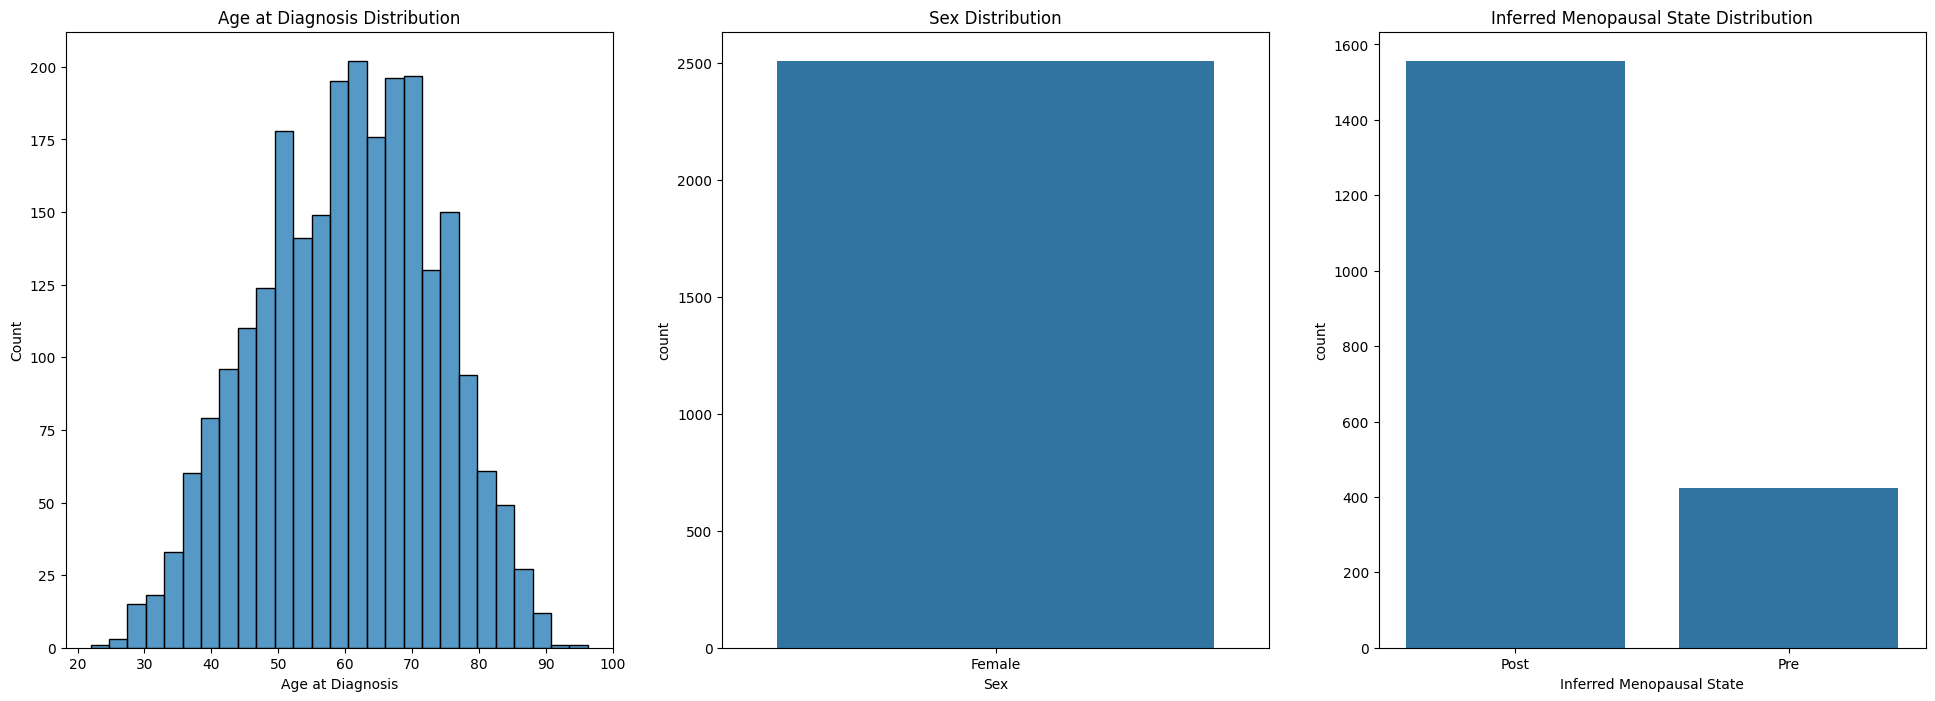

In [7]:
fig, axes = plt.subplots(figsize=(24, 8), ncols=3, nrows=1)
sns.histplot(data=df, x="Age at Diagnosis", ax=axes[0])
sns.countplot(data=df, x="Sex", ax=axes[1])
sns.countplot(data=df, x="Inferred Menopausal State", ax=axes[2])

axes[0].set_title("Age at Diagnosis Distribution")
axes[1].set_title("Sex Distribution")
axes[2].set_title("Inferred Menopausal State Distribution")

plt.show()

## Fill Null Values


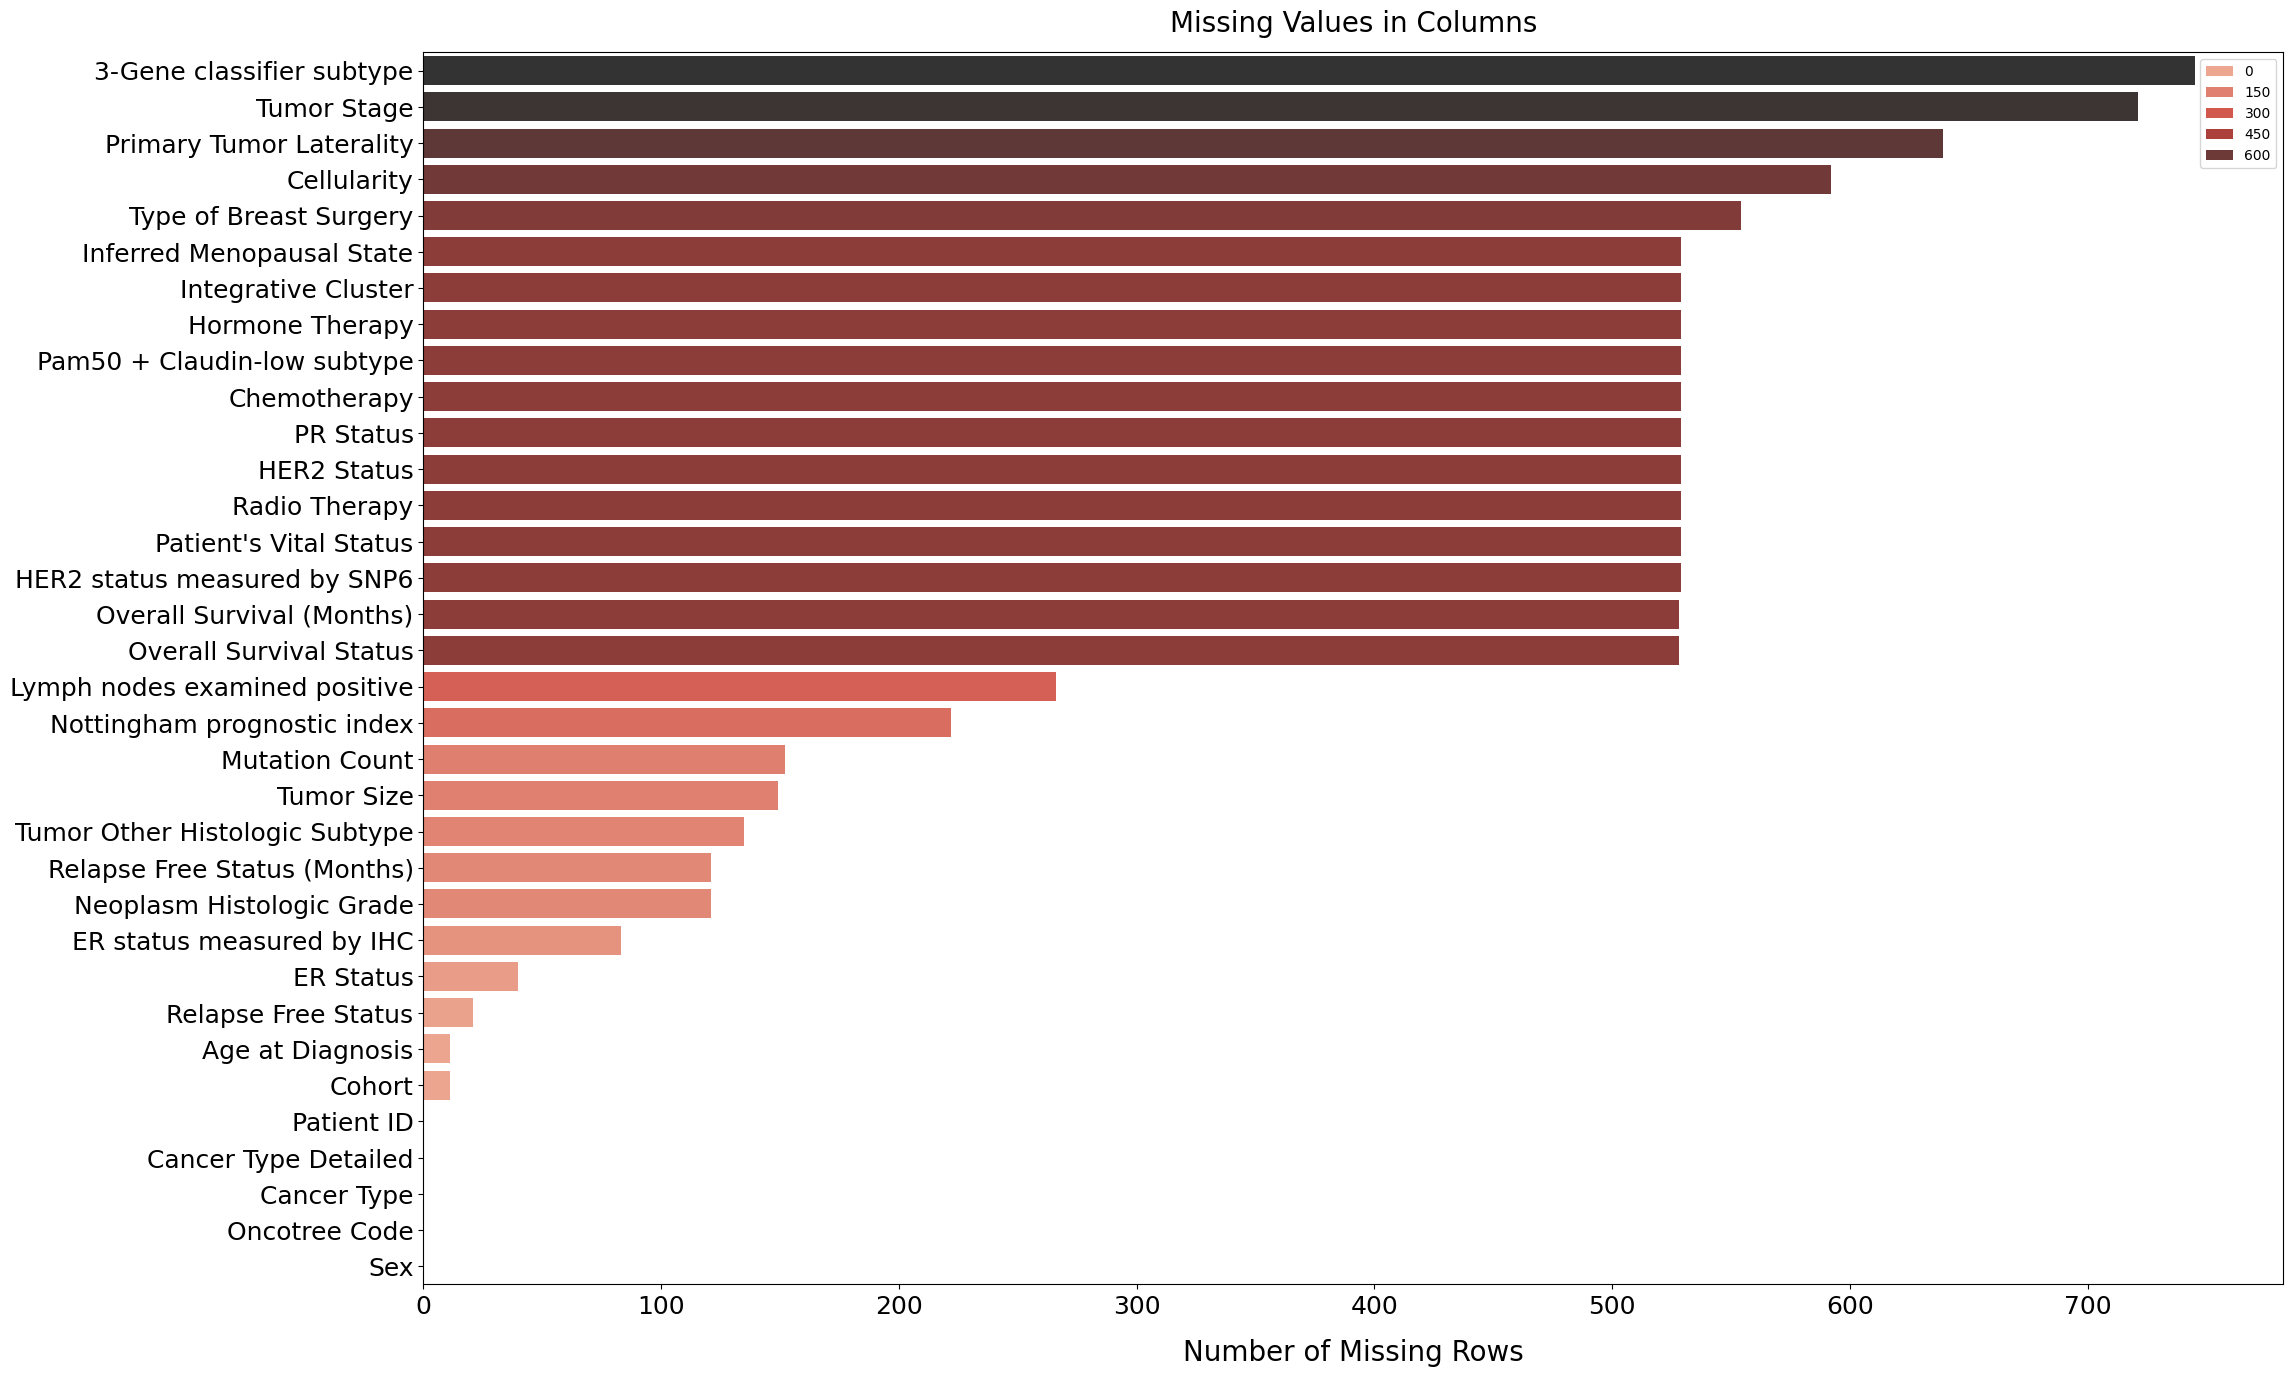

In [8]:
fig = plt.figure(figsize=(24, 16))

sns.barplot(
    x=df.isnull().sum().sort_values(ascending=False).values,
    y=df.isnull().sum().sort_values(ascending=False).index,
    palette="Reds_d",
    hue=df.isnull().sum().sort_values(ascending=False).values,
)

plt.xlabel("Number of Missing Rows", size=20, labelpad=15)
plt.ylabel("")
plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=18)
plt.title("Missing Values in Columns", size=20, pad=15)

plt.show()

In order to fill in the null values, we have to decide which can be reliable for other to depend on. From the above plot, the cancer detailed type can be used to fill the null values as it has 0 missing values. One way of doing that is to group the patients by `Cancer Type Detailed` and then use the most frequent value of their groups to fill in


### Features depend on Cancer Type Detailed


### Clinical outcome columns


In [9]:
df["Type of Breast Surgery"] = (
    df.groupby(["Cancer Type Detailed"])["Type of Breast Surgery"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)

In [10]:
# Fill event and duration null values with the mean or the most frequent value
grouped_df = df.groupby(["Cancer Type Detailed"])["Relapse Free Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Relapse Free Status"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Relapse Free Status (Months)"].apply(
    lambda x: x.fillna(x.mean())
)
df["Relapse Free Status (Months)"] = grouped_df.sort_index(level=1).values

In [11]:
# Since the relapse free status has two classes, we have to have two level of grouping
grouped_df = df.groupby(["Cancer Type Detailed", "Relapse Free Status"])[
    "Overall Survival Status"
].apply(lambda x: x.fillna(x.mode()[0]))
df["Overall Survival Status"] = grouped_df.sort_index(level=2).values
grouped_df = df.groupby(["Cancer Type Detailed", "Overall Survival Status"])[
    "Overall Survival (Months)"
].apply(lambda x: x.fillna(x.mean()))
df["Overall Survival (Months)"] = grouped_df.sort_index(level=2).values

In [12]:
# Fill null values in treatment columns with mode of each cancer type detailed
# For each cancer type detailed, find the mode of each treatment column and fill null values with that mode
grouped_df = df.groupby(["Cancer Type Detailed"])["Chemotherapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Chemotherapy"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Hormone Therapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Hormone Therapy"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Radio Therapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Radio Therapy"] = grouped_df.sort_index(level=1).values

### Bio-markers columns


In [13]:
df["ER status measured by IHC"] = df["ER status measured by IHC"].fillna(
    df["ER status measured by IHC"].mode()[0]
)
grouped_df = df.groupby(["ER status measured by IHC"])["ER Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["ER Status"] = grouped_df.sort_index(level=1).values
df["HER2 status measured by SNP6"] = df["HER2 status measured by SNP6"].fillna(
    df["HER2 status measured by SNP6"].mode()[0]
)
grouped_df = df.groupby(["HER2 status measured by SNP6"])["HER2 Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["HER2 Status"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["PR Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["PR Status"] = grouped_df.sort_index(level=1).values

In [14]:
df["Pam50 + Claudin-low subtype"] = df["Pam50 + Claudin-low subtype"].fillna(
    df["Pam50 + Claudin-low subtype"].mode()[0]
)
df["3-Gene classifier subtype"] = (
    df.groupby(["Cancer Type Detailed"])["3-Gene classifier subtype"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
df["Integrative Cluster"] = (
    df.groupby(["Cancer Type Detailed"])["Integrative Cluster"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)

### Metadata columns


In [15]:
df["Cohort"] = (
    df.groupby(["Cancer Type Detailed"])["Cohort"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
df["Oncotree Code"]

0        IDC
1        IDC
2        IDC
3       MDLC
4       MDLC
        ... 
2504    BRCA
2505    BRCA
2506    BRCA
2507    BRCA
2508    BRCA
Name: Oncotree Code, Length: 2509, dtype: object

### Demographic column


In [16]:
# Fill null age at diagnosis with the mean age of each cancer type detailed
df["Age at Diagnosis"] = (
    df.groupby(["Cancer Type Detailed"])["Age at Diagnosis"]
    .apply(lambda x: x.fillna(x.mean()))
    .sort_index(level=1)
    .values
)

# Fill the inferred menopausal state with the common state
df["Inferred Menopausal State"] = df["Inferred Menopausal State"].fillna(
    df["Inferred Menopausal State"].mode()[0]
)

### Cancer characteristic columns


In [17]:
df["Cellularity"] = (
    df.groupby(["Cancer Type Detailed"])["Cellularity"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
# Need to have fall back mechanism as their exists cases where all cellularity values are null for a given cancer type detailed
df["Tumor Stage"] = (
    df.groupby(["Cancer Type Detailed", "Cellularity"])["Tumor Stage"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=2)
    .values
)
df["Tumor Stage"] = (
    df.groupby(["Cancer Type Detailed"])["Tumor Stage"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=1)
    .values
)
# 3 fallback levels to fill tumor size as there exists cases where all tumor size values are null for a given cancer type detailed and tumor stage
df["Tumor Size"] = (
    df.groupby(["Cancer Type Detailed", "Tumor Stage"])["Tumor Size"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=2)
    .values
)
df["Tumor Size"] = (
    df.groupby(["Cancer Type Detailed"])["Tumor Size"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=1)
    .values
)
df["Tumor Size"] = df["Tumor Size"].fillna(df["Tumor Size"].median())
# 2 fallback levels to fill neoplasm histologic grade as there exists cases where all neoplasm histologic grade values are null for a given cancer type detailed
df["Neoplasm Histologic Grade"] = (
    df.groupby(["Cancer Type Detailed"])["Neoplasm Histologic Grade"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Neoplasm Histologic Grade"] = df["Neoplasm Histologic Grade"].fillna(
    df["Neoplasm Histologic Grade"].mode()[0]
)
df["Tumor Other Histologic Subtype"] = (
    df.groupby(["Cancer Type Detailed"])["Tumor Other Histologic Subtype"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Tumor Other Histologic Subtype"] = df["Tumor Other Histologic Subtype"].fillna(
    "Ductal/NST"
)
df["Primary Tumor Laterality"] = (
    df.groupby(["Cancer Type Detailed"])["Primary Tumor Laterality"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)

c:\Users\baoth\.conda\envs\survival_analysis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\baoth\.conda\envs\survival_analysis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\baoth\.conda\envs\survival_analysis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\baoth\.conda\envs\survival_analysis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Clinical metric cols


In [18]:
clinical_metrics_cols

['Lymph nodes examined positive',
 'Mutation Count',
 'Nottingham prognostic index']

In [19]:
df["Lymph nodes examined positive"] = (
    df.groupby(["Cancer Type Detailed"])["Lymph nodes examined positive"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Lymph nodes examined positive"] = df["Lymph nodes examined positive"].fillna(
    df["Lymph nodes examined positive"].mode()[0]
)
df["Mutation Count"] = (
    df.groupby(["Cancer Type Detailed"])["Mutation Count"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Mutation Count"] = df["Mutation Count"].fillna(df["Mutation Count"].mode()[0])
df["Nottingham prognostic index"] = (
    df.groupby(["Tumor Size"])["Nottingham prognostic index"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=1)
    .values
)
df["Nottingham prognostic index"] = df["Nottingham prognostic index"].fillna(
    df["Nottingham prognostic index"].median()
)

c:\Users\baoth\.conda\envs\survival_analysis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\baoth\.conda\envs\survival_analysis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\baoth\.conda\envs\survival_analysis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\baoth\.conda\envs\survival_analysis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\baoth\.conda\envs\survival_analysis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\baoth\.conda\envs\sur

In [20]:
# drop patient vital status as it is redundant with overall survival status
df.drop(columns=["Patient's Vital Status", "Patient ID"], inplace=True)

In [21]:
df.describe(include=["object", "bool"])

,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,ER status measured by IHC,ER Status,HER2 status measured by SNP6,HER2 Status,...,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Oncotree Code,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status,Sex,3-Gene classifier subtype
count,2509,2509,2509,2509,2509,2509,2509,2509,2509,2509,...,2509,2509,2509,2509,2509,2509,2509,2509,2509,2509
unique,2,2,8,3,2,7,2,2,4,2,...,2,11,2,8,2,2,2,2,1,4
top,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,Positve,Positive,Neutral,Negative,...,Post,8,Left,IDC,Deceased,Positive,Yes,Not Recurred,Female,ER+/HER2- High Prolif
freq,1721,2506,1865,1486,2097,1229,1900,1865,1965,2262,...,2085,627,1552,1865,1343,1478,1609,1507,2509,1129


## Encode the textual data


In [22]:
numeric_cols = df._get_numeric_data().columns
categorical_cols = df.select_dtypes(include=["object", "bool"]).columns

In [23]:
object_cols = [
    "Type of Breast Surgery",
    "Cancer Type",
    "Cancer Type Detailed",
    "Cellularity",
    "Chemotherapy",
    "Chemotherapy",
    "Pam50 + Claudin-low subtype",
    "ER status measured by IHC",
    "ER Status",
    "HER2 status measured by SNP6",
    "HER2 Status",
    "Tumor Other Histologic Subtype",
    "Hormone Therapy",
    "Inferred Menopausal State",
    "Integrative Cluster",
    "Primary Tumor Laterality",
    "Oncotree Code",
    "PR Status",
    "Radio Therapy",
    "Sex",
    "3-Gene classifier subtype",
]

for col in object_cols:
    df[col] = np.uint8(LabelEncoder().fit_transform(df[col]))

df["Overall Survival Status"] = np.uint8(
    df["Overall Survival Status"].map({"Living": 0, "Deceased": 1})
)
df["Relapse Free Status"] = np.uint8(
    df["Relapse Free Status"].map({"Not Recurred": 0, "Recurred": 1})
)

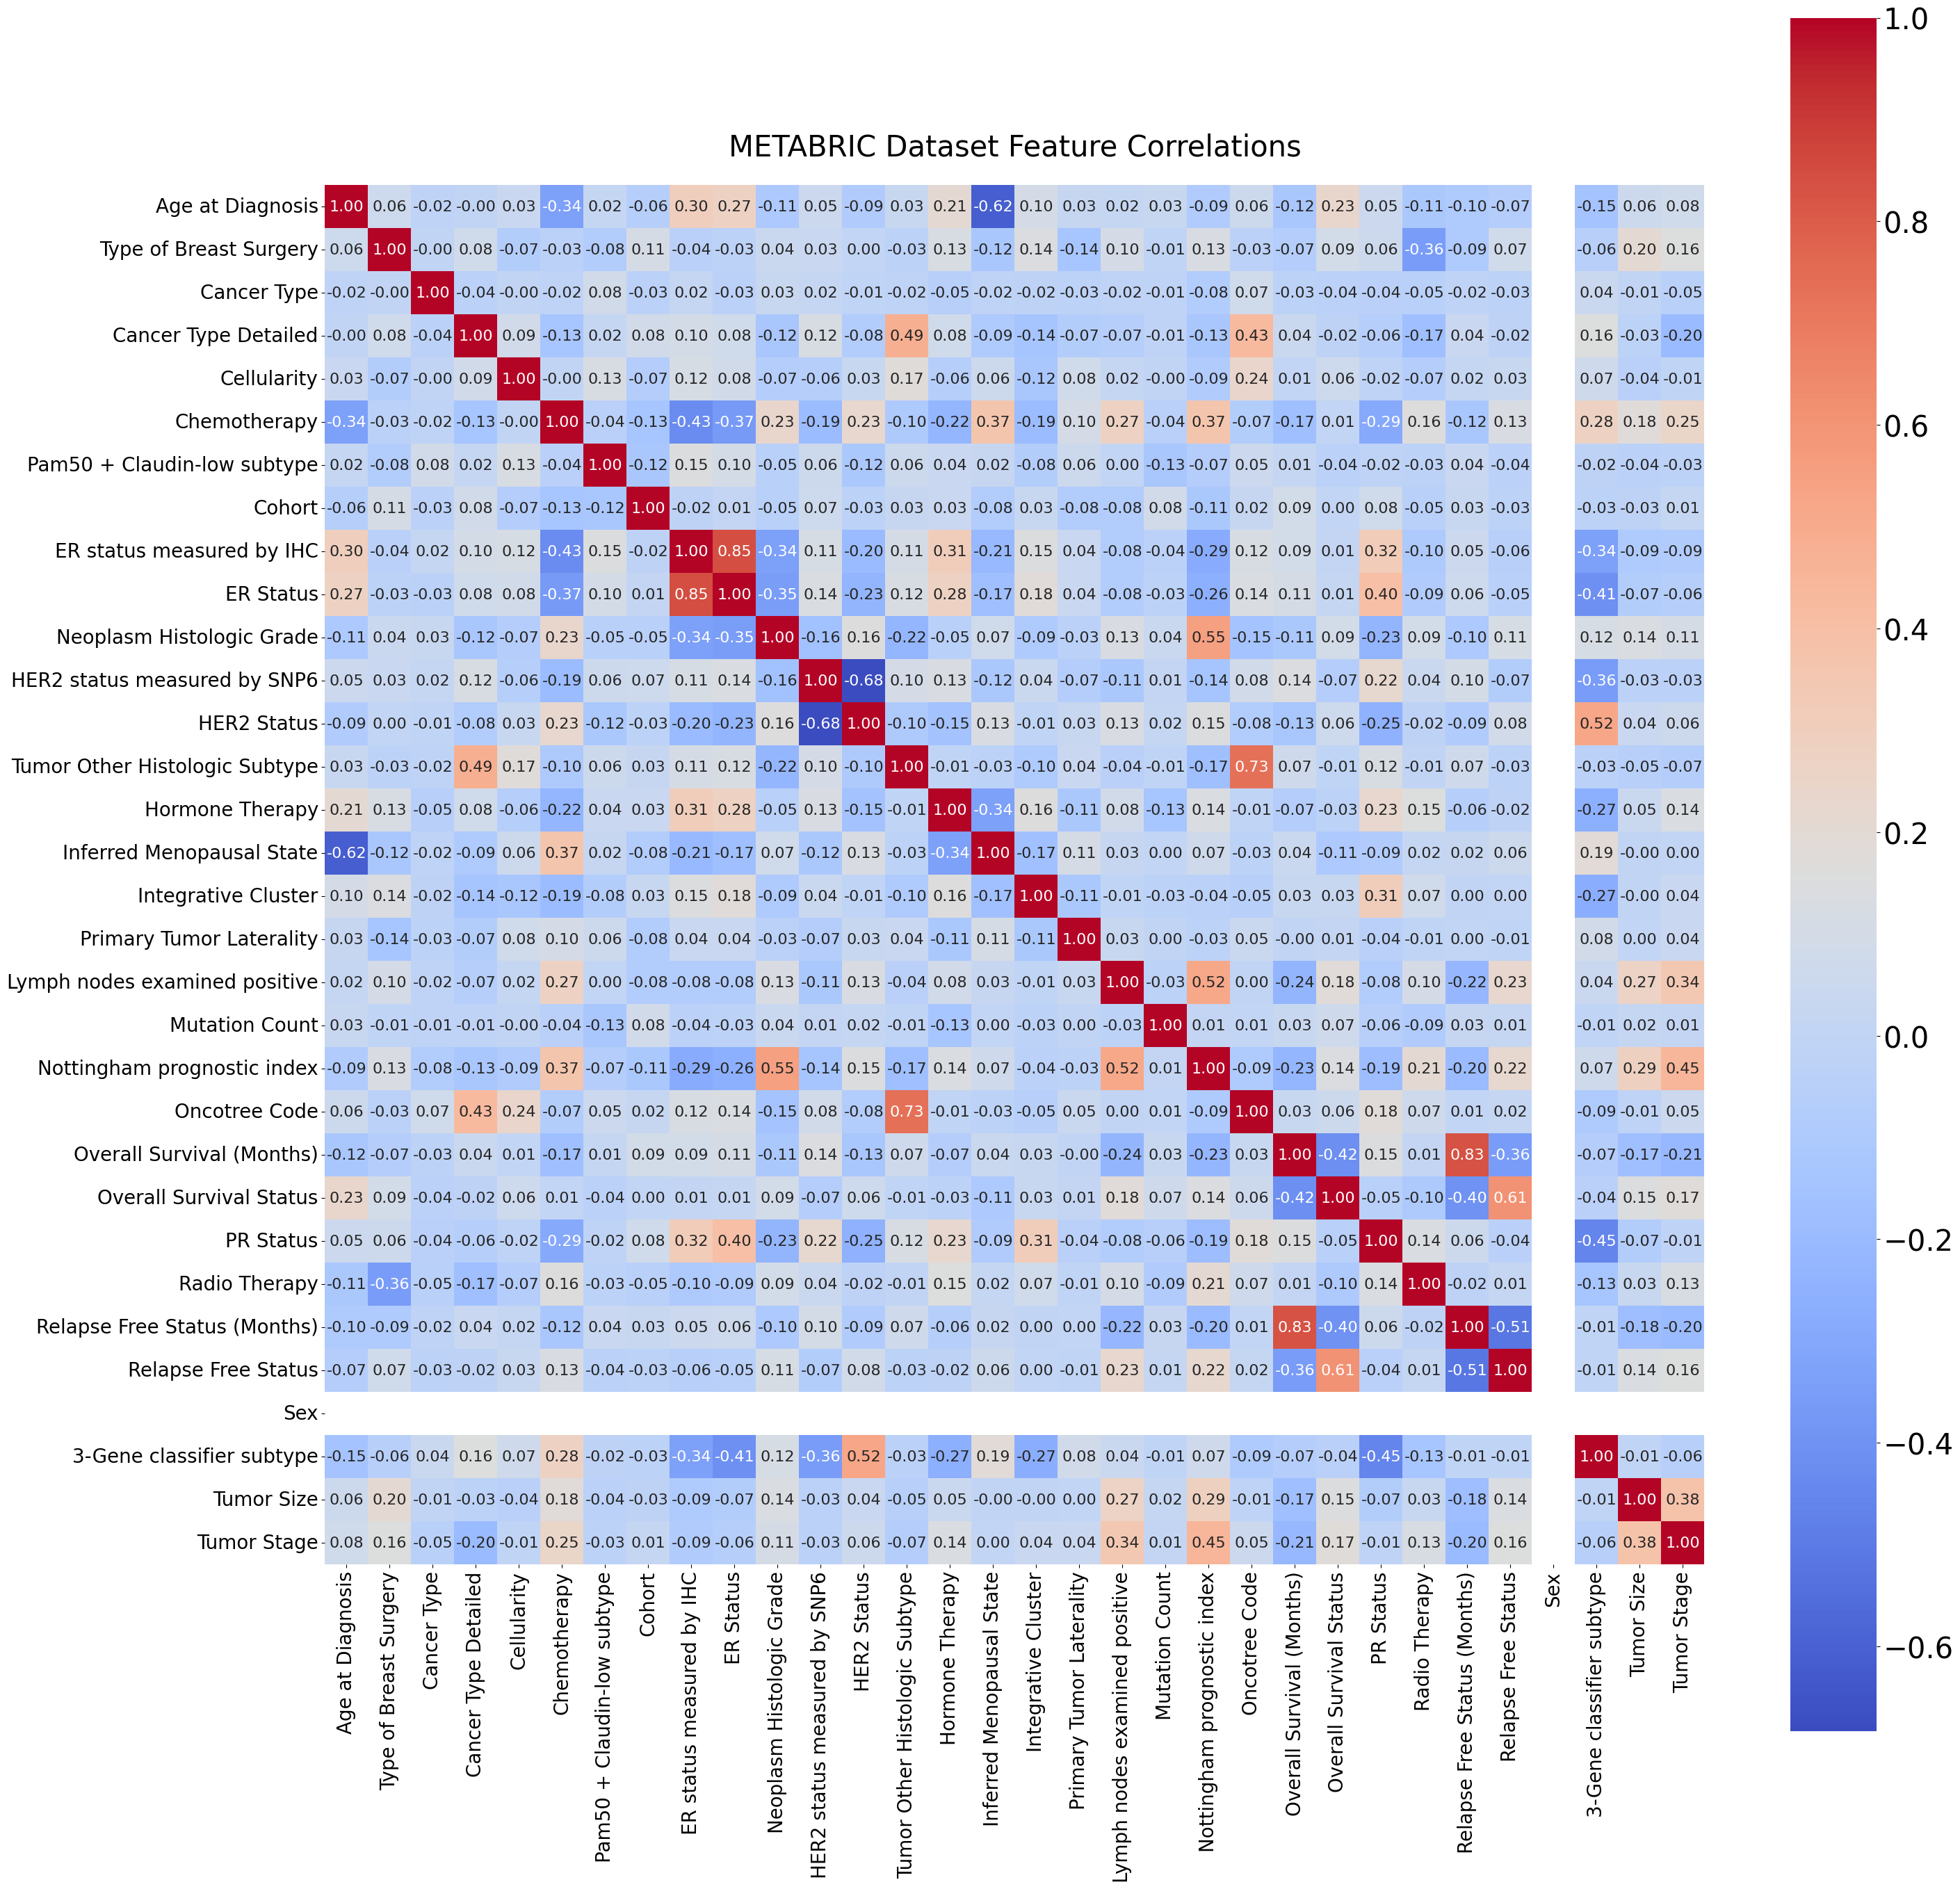

In [24]:
fig = plt.figure(figsize=(32, 32), dpi=100)

ax = sns.heatmap(
    df.corr(),
    annot=True,
    square=True,
    cmap="coolwarm",
    annot_kws={"size": 16},
    fmt=".2f",
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.tick_params(axis="x", labelsize=20, rotation=90)
plt.tick_params(axis="y", labelsize=20, rotation=0)
plt.title("METABRIC Dataset Feature Correlations", size=30, pad=30)

plt.show()

In [25]:
df.head()

,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,...,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage
0,75.65,1,0,2,0,0,6,1.0,1,1,...,140.500000,0,0,1,138.65,0,0,2,22.0,2.0
1,43.19,0,0,2,0,0,2,1.0,1,1,...,84.633333,0,1,1,83.52,0,0,0,10.0,1.0
2,48.87,1,0,2,0,1,3,1.0,1,1,...,163.700000,1,1,0,151.28,1,0,0,15.0,2.0
3,47.68,1,0,5,2,1,3,1.0,1,1,...,164.933333,0,1,1,162.76,0,0,1,25.0,2.0
4,76.97,1,0,5,0,1,3,1.0,1,1,...,41.366667,1,1,1,18.55,1,0,0,40.0,2.0


In [26]:
df.columns

Index(['Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type',
       'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
       'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC',
       'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage'],
      dtype='object')

# Survival analysis model


In [27]:
patient_meta_cols = ["Patient ID", "Oncotree Code", "Cohort"]
demographic_cols = ["Age at Diagnosis", "Sex", "Inferred Menopausal State"]
cancer_characteristics_cols = [
    "Cancer Type",
    "Cancer Type Detailed",
    "Cellularity",
    "Neoplasm Histologic Grade",
    "Tumor Other Histologic Subtype",
    "Tumor Size",
    "Tumor Stage",
    "Primary Tumor Laterality",
]
biomarker_cols = [
    "ER Status",
    "ER status measured by IHC",
    "PR Status",
    "HER2 Status",
    "HER2 status measured by SNP6",
    "Pam50 + Claudin-low subtype",
    "3-Gene classifier subtype",
    "Integrative Cluster",
]
treatment_cols = [
    "Type of Breast Surgery",
    "Hormone Therapy",
    "Chemotherapy",
    "Radio Therapy",
]
clinical_outcome_cols = [
    "Overall Survival (Months)",
    "Overall Survival Status",
    "Relapse Free Status (Months)",
    "Relapse Free Status",
]
clinical_metrics_cols = [
    "Lymph nodes examined positive",
    "Mutation Count",
    "Nottingham prognostic index",
]

In [28]:
features = (
    demographic_cols
    + cancer_characteristics_cols
    + biomarker_cols
    + treatment_cols
    + clinical_metrics_cols
)
overall_survival_cols = ["Overall Survival (Months)", "Overall Survival Status"]
relapse_free_cols = ["Relapse Free Status (Months)", "Relapse Free Status"]

In [29]:
# Assuming 'df' is your Pandas DataFrame
# 'features' are your independent variables, 'target' is your dependent variable
X = df[features]
y = df[overall_survival_cols]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state
)

## Metabric Dataset


In [30]:
class MetabricDataset(Dataset):
    def __init__(self, X, y):
        self.features = X
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.features[idx]
        label = self.labels[idx]
        return data, label

## Model Base Class


In [81]:
class BaseSurvivalClass(nn.Module):
    def __init__(self):
        super(BaseSurvivalClass, self).__init__()
        self.features = features
        self.categorical_cols = [
            col for col in categorical_cols if col in self.features
        ]
        self.numerical_cols = [col for col in numeric_cols if col in self.features]
        self.embeddings = nn.ModuleDict()
        for col in self.categorical_cols:
            num_unique_values = int(df[col].nunique())
            embedding_size = 8
            self.embeddings[col] = nn.Embedding(num_unique_values, embedding_size)

    def embed(self, x):
        embedded_cols = []
        for col in self.categorical_cols:
            # ndarray = np.array()
            embedded_col = self.embeddings[col](x[:, self.features.index(col)].long())
            # print(embedded_col.shape)
            embedded_cols.append(embedded_col)
        numerical_data = torch.stack(
            [
                torch.tensor(x[:, self.features.index(col)])
                for col in self.numerical_cols
            ],
            dim=1,
        ).float()
        x = torch.cat(embedded_cols + [numerical_data], dim=1)
        return x

    def forward(self, x):
        raise NotImplementedError("Forward method not implemented!")

## Simple Neural Network


In [82]:
class NeuralNetwork(BaseSurvivalClass):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(1),
            nn.Softplus(),
        )

    def forward(self, x):
        x = self.embed(x)
        return self.net(x).squeeze()

In [83]:
class NLL(nn.Module):
    def __init__(self, initial_lambda=0.1):
        super().__init__()
        self.log_lambda = nn.Parameter(torch.tensor(np.log(initial_lambda)))

    def forward(self, preds, failure_times, is_observed):
        # Number of observed events
        d = torch.sum(is_observed)
        log_of_sum = torch.log(torch.sum(preds * failure_times) + 1e-8)
        sum_of_log = torch.sum(is_observed * torch.log(preds))

        nll = d * log_of_sum - sum_of_log
        return nll

## CoxPH model


In [84]:
class CoxPH(BaseSurvivalClass):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(1),
        )

    def forward(self, x):
        x = self.embed(x)
        return self.net(x).squeeze()


class CoxPHLoss(nn.Module):
    """
    Cox Proportional Hazards partial likelihood loss.
    Efficient implementation using the Breslow approximation for tied events.
    """

    def __init__(self):
        super().__init__()

    def forward(self, log_h, durations, events):
        """
        Args:
            log_h: log hazard ratio predictions from model, shape (batch_size,)
            durations: observed time (either event or censoring time), shape (batch_size,)
            events: event indicator (1 if event, 0 if censored), shape (batch_size,)

        Returns:
            loss: negative log partial likelihood
        """
        # Sort by time
        sorted_durations, sorted_indices = torch.sort(durations)
        sorted_log_h = log_h[sorted_indices]
        sorted_events = events[sorted_indices]

        # Calculate negative partial log-likelihood
        log_likelihood = 0.0

        for i in range(len(sorted_durations)):
            if sorted_events[i] == 1:  # If an event occurred
                # Risk set: all individuals still at risk at time t_i
                # (includes individual i and all individuals with longer times)
                risk_set_log_h = sorted_log_h[i:]

                # Log partial likelihood contribution
                # log h_i - log(sum of exp(log h_j) for j in risk set)
                log_likelihood += sorted_log_h[i] - torch.logsumexp(
                    risk_set_log_h, dim=0
                )

        return -log_likelihood  # Return negative for minimization

## Fitting model


In [137]:
train_dataset = MetabricDataset(X_train.to_numpy(), y_train.to_numpy())
test_dataset = MetabricDataset(X_test.to_numpy(), y_test.to_numpy())

In [138]:
learning_rate = 0.001
batch_size = 64
epochs = 200

In [139]:
# model = NeuralNetwork().to(device)
# loss_fn = NLL().to(device)

model = CoxPH().to(device)  
loss_fn = CoxPHLoss().to(device)

In [140]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [141]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [142]:
for feature, label in train_loader:
    feature = feature.to(torch.float32).to(device)
    label = label.to(torch.float32).to(device)

    preds = model(feature)
    loss = loss_fn(preds, label[:, 0], label[:, 1])
    print(loss)
    break

tensor(121.4839, device='cuda:0', grad_fn=<NegBackward0>)


C:\Users\baoth\AppData\Local\Temp\ipykernel_15564\3336366053.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


In [143]:
for feature, label in train_loader:
    feature = feature.to(torch.float32).to(device)
    label = label.to(torch.float32).to(device)

    preds = model(feature)
    print(label[:, 1])
    print(preds)
    break

tensor([1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.0916, 0.0720, 0.0925, 0.0857, 0.0723, 0.0867, 0.0951, 0.1005, 0.0948,
        0.0881, 0.0809, 0.0959, 0.0759, 0.0740, 0.1154, 0.0711, 0.0880, 0.0969,
        0.0955, 0.0956, 0.0990, 0.0517, 0.0936, 0.0833, 0.1086, 0.1045, 0.0867,
        0.0816, 0.0831, 0.0802, 0.1015, 0.0659, 0.0566, 0.1104, 0.0825, 0.1009,
        0.0888, 0.0781, 0.1098, 0.0928, 0.0854, 0.0788, 0.0551, 0.0957, 0.0752,
        0.0756, 0.0827, 0.0951, 0.0788, 0.0869, 0.0944, 0.0845, 0.0663, 0.0908,
        0.0781, 0.0768, 0.0869, 0.0782, 0.0652, 0.0995, 0.0852, 0.0952, 0.0837,
        0.0988], device='cuda:0', grad_fn=<SqueezeBackward0>)


C:\Users\baoth\AppData\Local\Temp\ipykernel_15564\3336366053.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


In [144]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size=64):
    accum_loss = 0
    for feature, label in dataloader:
        X = feature.to(torch.float32).to(device)
        y = label.to(torch.float32).to(device)

        preds = model(X)
        loss = loss_fn(preds, y[:, 0], y[:, 1])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accum_loss += loss.item()
    return accum_loss / len(dataloader)

In [145]:
train_loop(train_loader, model, loss_fn, optimizer)

C:\Users\baoth\AppData\Local\Temp\ipykernel_15564\3336366053.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


115.17904199872699

In [146]:
c_indices = []
average_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_loss = train_loop(train_loader, model, loss_fn, optimizer)
    average_losses.append(epoch_loss)

    scheduler.step()

    # After each epoch, evaluate C-index
    model.eval()
    with torch.no_grad():
        all_risks = []
        all_times = []
        all_events = []

        for feature, label in test_loader:
            feature = feature.to(torch.float32).to(device)
            risks = model(feature)

            all_risks.append(risks)
            all_times.append(label[:, 0])  # Event times
            all_events.append(label[:, 1])  # Event indicators

        all_risks = torch.cat(all_risks)
        all_times = torch.cat(all_times)
        all_events = torch.cat(all_events)

        c_idx = c_index(all_risks, all_times, all_events)
        c_indices.append(c_idx)
        print(f"C-index: {c_idx:.4f}")
print("Done!")

Epoch 1
-------------------------------


C:\Users\baoth\AppData\Local\Temp\ipykernel_15564\3336366053.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


Concordant: 124279
Discordant: 60495
Tied Risk: 0
Tied Time: 728
C-index: 0.6726
Epoch 2
-------------------------------
Concordant: 123870
Discordant: 60904
Tied Risk: 0
Tied Time: 728
C-index: 0.6704
Epoch 3
-------------------------------
Concordant: 125977
Discordant: 58797
Tied Risk: 0
Tied Time: 728
C-index: 0.6818
Epoch 4
-------------------------------
Concordant: 125290
Discordant: 59484
Tied Risk: 0
Tied Time: 728
C-index: 0.6781
Epoch 5
-------------------------------
Concordant: 125780
Discordant: 58994
Tied Risk: 0
Tied Time: 728
C-index: 0.6807
Epoch 6
-------------------------------
Concordant: 126425
Discordant: 58349
Tied Risk: 0
Tied Time: 728
C-index: 0.6842
Epoch 7
-------------------------------
Concordant: 127346
Discordant: 57427
Tied Risk: 1
Tied Time: 728
C-index: 0.6892
Epoch 8
-------------------------------
Concordant: 124242
Discordant: 60532
Tied Risk: 0
Tied Time: 728
C-index: 0.6724
Epoch 9
-------------------------------
Concordant: 126537
Discordant: 5

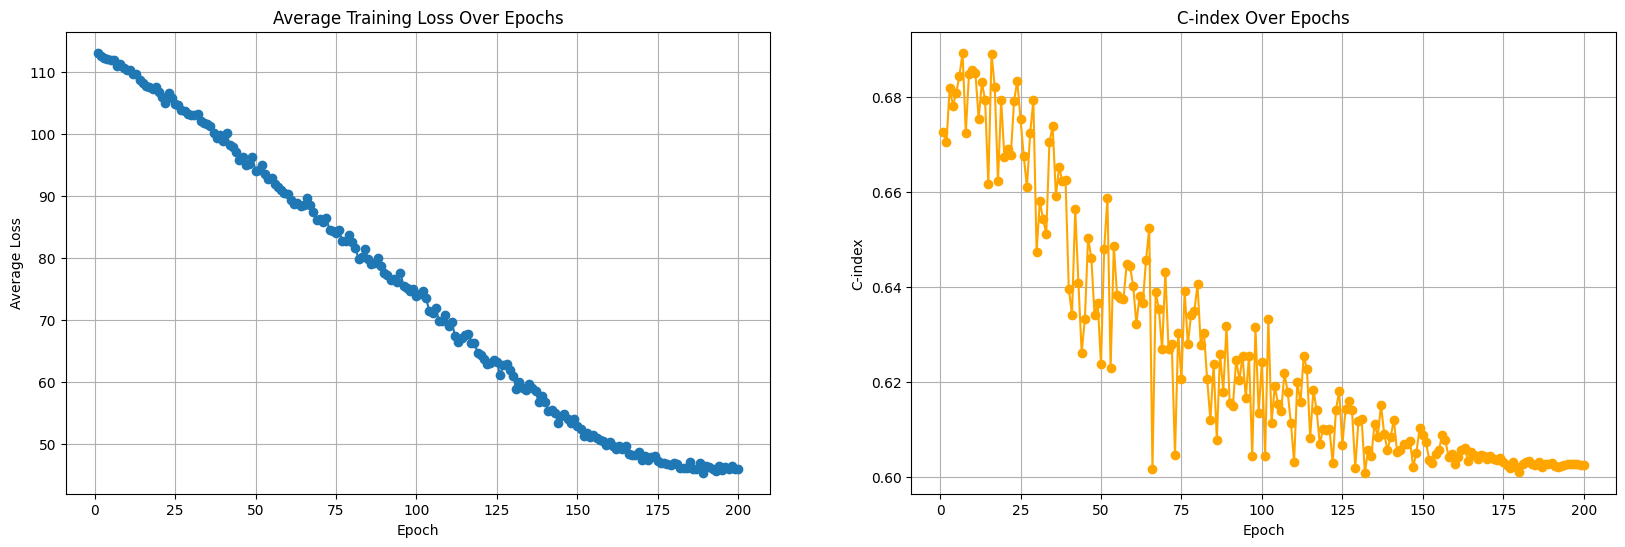

In [152]:
figure, axes = plt.subplots(figsize=(20, 6), ncols=2, nrows=1)
axes[0].plot(range(1, epochs + 1), average_losses, marker="o")
axes[0].set_title("Average Training Loss Over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Average Loss")
axes[0].grid()
axes[1].plot(range(1, epochs + 1), c_indices, marker="o", color="orange")
axes[1].set_title("C-index Over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("C-index")
axes[1].grid()
plt.show()